# Image Classification on Flowers with CNN and Transfer Learning

In this project, we will use machine learning to simulate mobile apps, where users can take a photo and the app will output the species name of that flower - a flower recognition app. 

The dataset we will be using can be aquired from Kaggle through the link here In order to train the data, we introduce around 15,000 images of 16 different flower species, and split them into train, test, validation sets. We will use a baseline logistic regression model and finally complete this task using a CNN model. Furthermore, a basic prediction UI will be developed in this notebook, where it takes the path (or the web link) to a certain image and outputs its species. 

The data used in this project can be found publically on Kaggle through the link [here](https://www.kaggle.com/datasets/l3llff/flowers). 

In [1]:
# import the usual packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# import Logistic Regression model from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

# import pickle to save our Logistic Regression model
import pickle

# import TF tools
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model

# import Early Stopping steps from Keras
from tensorflow.keras.callbacks import EarlyStopping

# import VGG16 model for transfer learning
from tensorflow.keras.applications import VGG16

# import CV2 to reshape our images for model input
import cv2

# import OS to manipulate folders
import os

# helper package to split images into training, testing, validation sets
import splitfolders

In [2]:
# a helper function to migrate images from ImageDataGenerator to pandas DataFrame
def generator_to_df(generator, flatten=True):
    
    """
    Iterate through the ImageDataGenerator and returns all flattened images to X dataset and labels to y dataset. 
    
    generator -- The ImageDataGenerator to migrate images from
    flatten -- Rser defined parameter, return a flattened 2D tensor if True. Default is True
    
    """
    
    # minimal iterations to generate all images
    iterations = generator.n // generator.batch_size
    
    # initiate our first iteration
    X, y = generator.next()

    i = 0

    while i < iterations:
        X_next, y_next = generator.next()
        X = np.append(X, X_next, axis=0)
        y = np.append(y, y_next, axis=0)

        i += 1

    # flatten
    if flatten:
        X = X.reshape(X.shape[0], X.shape[1] * X.shape[2] * X.shape[3])
        y = np.argmax(y, axis=1)

    # reset our generator
    generator.reset()
    
    print(f'{X.shape[0]} images were loaded into DataFrame.')
    
    return X, y

In [3]:
# a UI function to take an image as input and output its predicted species
def model_predict(model, path):
    
    """
    return the model prediction of species, given an image of the test folder. 
    
    model -- The model fore prediction
    path -- Path to the test image on local machine, should follow the format of species/file_name. 
    """
    
    species = path.split('/')[0]
    folder_path = test_path + path
    
    # read the image
    img = mpimg.imread(folder_path)
    img = cv2.resize(img, dsize=(128, 128))

    # display the image
    plt.figure()
    plt.title(f'actual species class: {species}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # prediction
    predicted_results = model.predict(img.reshape(1, 128, 128, 3))
    predicted_ind = np.argmax(predicted_results)
    predicted_prob = predicted_results.max()
    predicted_species = species_list[predicted_ind]
    
    print(f'predicted to be {predicted_species}, with a probability of {predicted_prob}')

# Basic EDA

Our data came in one big folder in the `flowers` folder, in which images of different species are split into different folders. We introduce the `splitfolders` package to split our big folder into train, test, validation folders. But before that, we may also notice that some of our data are irrelevant to flowers (such as closeups, arts, etc.). We will have to manually remove them from a copy of the entire dataset before folder split. 

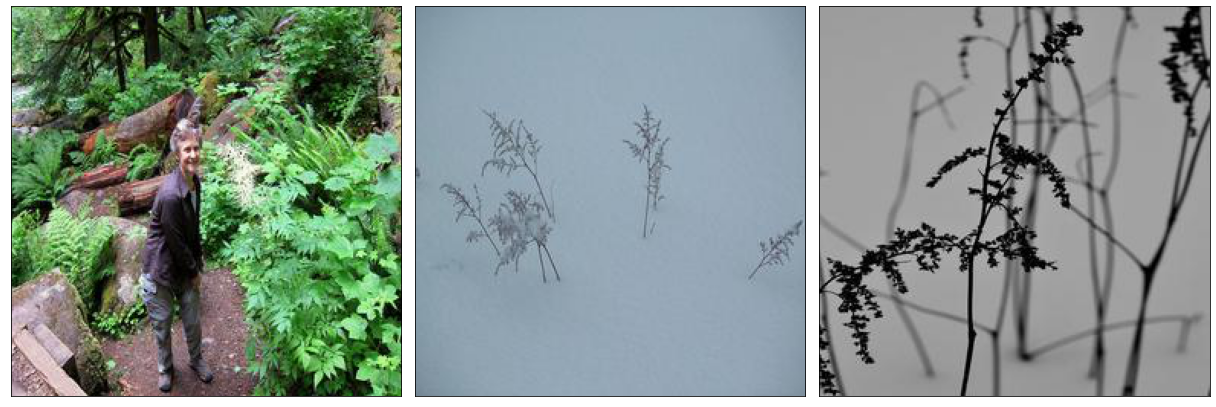

In [4]:
# examples irrelevant images through the species
my_list = ['flowers/astilbe/7522117202_d1e04008e0_c.jpg', 
           'flowers/astilbe/8512808629_20862d5a81_c.jpg', 
           'flowers/astilbe/8314415403_63ef5fd3dd_c.jpg']

fig, ax = plt.subplots(1, 3, figsize=(17, 10))

ax = ax.flatten()

for i in range(len(my_list)):
    image_array = mpimg.imread(my_list[i])
    
    ax[i].imshow(image_array)
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    
plt.tight_layout()

We will try to remove as many of such images as possible as these would confuse our models. Also, we will exclude astilbe as they all came in clusters, which is hard to be analized. 

The cleaned images will be saved in `flowers_cleaned` colder. Then, we will perform train, test, valication split. The ratio is set to be `0.7`, `0.15`, `0.15`. We can take a look at the number of images for each species in each folder. 

In [5]:
# create folder flowers_cleaned from data_cleaned if not exist
if 'data_cleaned' not in os.listdir():
    splitfolders.ratio('flowers_cleaned', 'data_cleaned', ratio=(0.7, 0.15, 0.15))

All the cleaned images are saved in the `data_cleaned` folder, split into train, test and validation sets. 

In [6]:
# specify the paths
train_path = 'data_cleaned/train/'
test_path = 'data_cleaned/test/'
val_path = 'data_cleaned/val/'

paths = [train_path, test_path, val_path]

In total, we have 14070 images


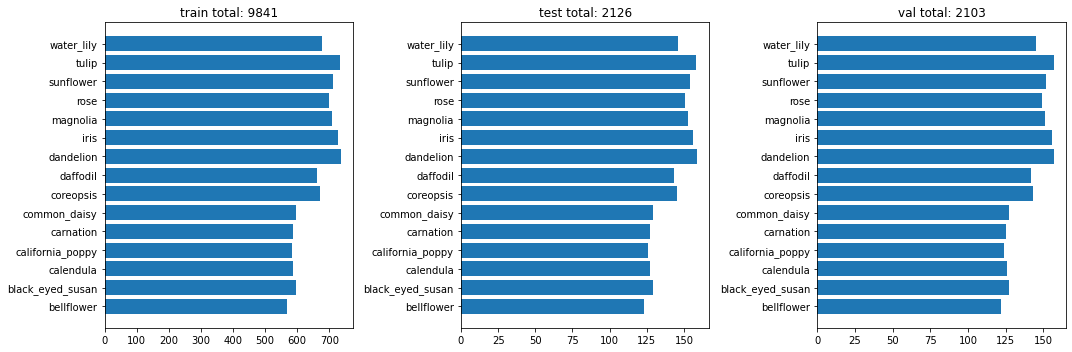

In [7]:
# scan our data
species_list = os.listdir(train_path)
total_images = []

i = 0
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax = ax.flatten()

while i <= 2:
    folder_name = paths[i].split('/')[1]
    path = paths[i]
    
    n_species = []
    for species in species_list:
        n_species.append(len(os.listdir(path + species)))
    
    ax[i].barh(species_list, n_species)
    ax[i].set_title(f'{folder_name} total: {sum(n_species)}')
    total_images.append(sum(n_species))
    
    i += 1
    
plt.tight_layout()

print(f'In total, we have {sum(total_images)} images')

We can also take a look at the first sample image for each of the species in our training set. 

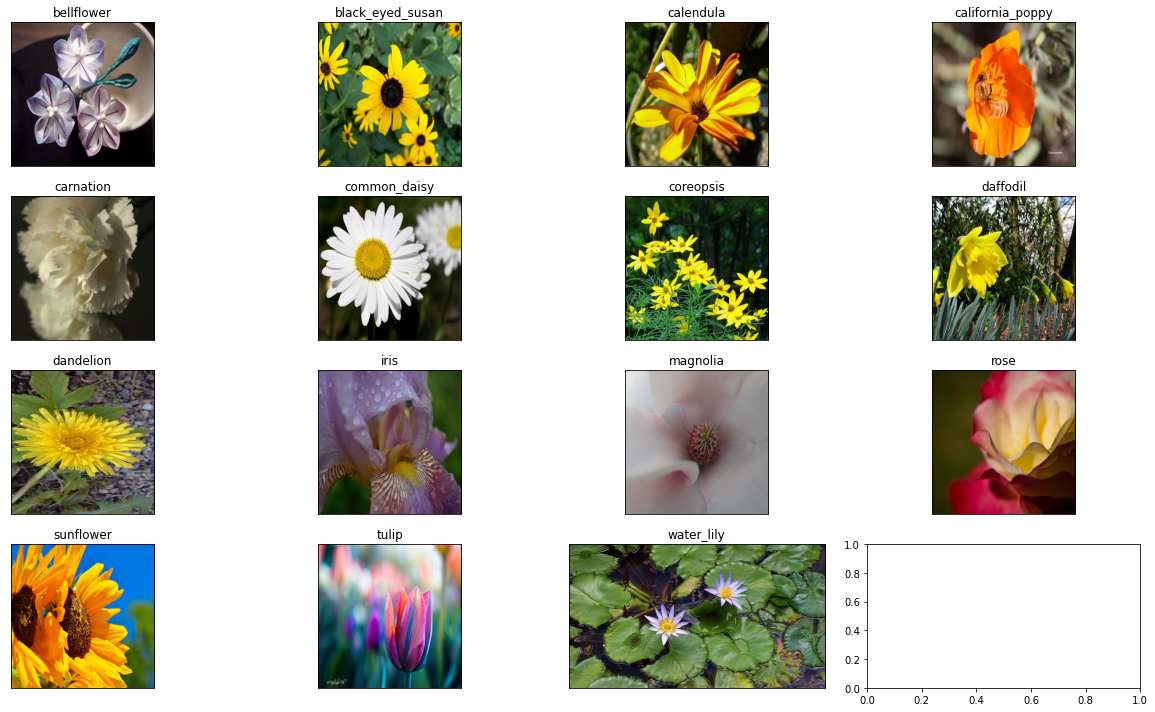

In [8]:
i = 0
n_species = len(species_list)

fig, ax = plt.subplots(4, 4, figsize=(17, 10))

ax = ax.flatten()

while i < n_species:
    species = species_list[i]
    
    path = train_path + species
    species_img = os.listdir(path)[0]
    
    image_array = mpimg.imread(path + '/' + species_img)
    
    ax[i].imshow(image_array)
    ax[i].set_title(species)
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    
    i += 1
    
plt.tight_layout()

We can see that our data came in in different shapes. We will use `ImageDataGenerator` to transform our images to the same shape and load them to our model incrementally. In the meantime, we will also spcify some random transformations to make our model more robust. 

# Baseline Logistic Regression Model

Let's use a basic Logistic Regression model for some baseline prediction. Due to the nature of Logistic Regression, we will try to shrink our images more so that our data won't be too wide. 

Given that our training set has only around 10k images, we will try to set our image size to 64 * 64. 

In [9]:
# specify the dimensions we want our images to be preprocessed to.This will allow us to use images of different resolutions
height = 64 
width = 64
channels = 3
batch_size = 128

# create image data generator

# we don't specify any image transformation here as this generator is prepared for logistic regression
datagen = ImageDataGenerator(rescale=1./255)

# specify where the images should be loaded from as well as some additional attributes:
train_generator=datagen.flow_from_directory(train_path, 
                                            target_size=(height,width), 
                                            color_mode='rgb', 
                                            batch_size=batch_size,
                                            class_mode='categorical')

val_generator=datagen.flow_from_directory(val_path, 
                                          target_size=(height,width), 
                                          color_mode='rgb', 
                                          batch_size=batch_size, 
                                          class_mode='categorical')

Found 9841 images belonging to 15 classes.
Found 2103 images belonging to 15 classes.


Let's take a look at some samples from our train generator. 

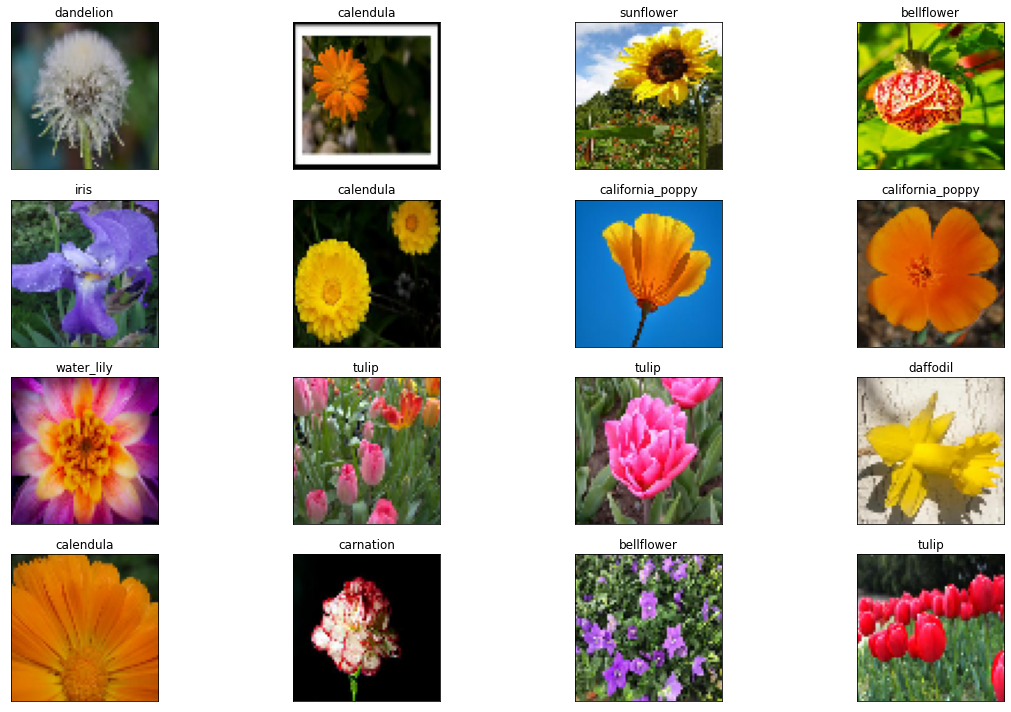

In [10]:
# grab a batch of images from our train generator: 
x, y = train_generator.next() 

# reset our generator
train_generator.reset()

# convert image labels from one-hot encoded into text
labels = np.argmax(y, axis=1)

i = 0
fig, ax = plt.subplots(4, 4, figsize=(17,10))

ax = ax.flatten()

while i <= 15:
    species = labels[i]
    
    ax[i].imshow(x[i])
    ax[i].set_title(species_list[species])
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    
    i += 1
    
plt.tight_layout()

Now, let's migrate these images to a Pandas DataFrame, which is to be fed into our Logistics Model. 

In [11]:
# store images from generator to dataframe, which is used to be fed into Logistic Regression model
X_train, y_train = generator_to_df(train_generator)
X_val, y_val = generator_to_df(val_generator)

9841 images were loaded into DataFrame.
2103 images were loaded into DataFrame.


In [12]:
%%time

# PLEASE RUN BELOW CELL TO SKIP THE TRAINING
# fit the model
my_logit = LogisticRegression(solver='saga', penalty='l1', C=5)
my_logit.fit(X_train, y_train)

# save our model
pickle.dump(my_logit, open('my_logit_model.pkl', 'wb'))

CPU times: total: 1h 2min 29s
Wall time: 1h 35min 39s


D:\Anaconda\envs\deeplearning\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [13]:
# PLEASE RUN THIS CELL TO SKIP THE TRAINING
# load our model if needed
try:
    my_logit
except:
    my_logit = pickle.load(open('my_logit_model.pkl', 'rb'))

In [14]:
print(f'training score: {my_logit.score(X_train, y_train)}')
print(f'testing score: {my_logit.score(X_val, y_val)}')

training score: 0.8431053754699726
testing score: 0.38611507370423204


It appears that Logistic Regrsssion model struggles a lot with such a task. We are seeing serious overfitting to our data. A possible assumption was that our image data are too generalized and include a lot of irrelevant patterns or objects (such as a hand holding a flower or flowers on a cake). Such patterns are hard to be analyzed by Logistics Regression, as it's looking at the images pixels by pixels and assign weights to each one of them. 

Another thing to point out is that it takes Logistic Regression around 50 min to finish the training. This is due to the fact that there are simply too many pixles, 64 * 64 = 4096 columns of data to be processed. 

Instead, we will mainly focus on CNN model, which looks at regions of patterns. 

# CNN

We will now mainly focus on CNN. Let's reset our generators with higher resolutions (to include more details), as well as some image transformations. 

In [15]:
# specify the dimensions we want our images to be preprocessed to
height = 128
width = 128
channels = 3
batch_size = 32
n_classes = 15

In [16]:
# create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# create validation image data generator.Only apply rescaling to our validation data.
val_datagen = ImageDataGenerator(rescale=1./255)

# specify where the images should be loaded from as well as some additional attributes:
train_generator=train_datagen.flow_from_directory(train_path,
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

val_generator=val_datagen.flow_from_directory(val_path, 
                                                 target_size=(height,width), 
                                                 color_mode='rgb', 
                                                 batch_size=batch_size, 
                                                 class_mode='categorical')

Found 9841 images belonging to 15 classes.
Found 2103 images belonging to 15 classes.


As a quick recap, CNN (Convolutional Neural Network) is a neural network that deals with image data. Specifically, it uses a set of kernels and apply calculation on the images, following a pre-defined steps. First stage convolutional calculations would identify simple lines, curves in images. If more kernels are further applied, our model can identify more complex structures, such as shapes, colors, even objects. Applying kernels would give us matrices of numbers, which would be fed to our layers as input. 

Finally, These calculated matrices would then be connected to fully connected layers to be streched and output as predictions. 

Instanciate the CNN model, which shrinks the images layers by layers.

In [17]:
my_CNN = Sequential()

# create simple CNN model architecture with Pooling for dimensionality reduction and Dropout to reduce overfitting
my_CNN.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (height, width, 3)))
my_CNN.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu'))
my_CNN.add(MaxPooling2D(pool_size=(2, 2)))
my_CNN.add(Dropout(0.20))

my_CNN.add(Conv2D(64, (3, 3), activation='relu'))
my_CNN.add(Conv2D(64, (3, 3), activation='relu'))
my_CNN.add(MaxPooling2D(pool_size=(2, 2)))
my_CNN.add(Dropout(0.20))

my_CNN.add(Conv2D(128, (3, 3), activation='relu'))
my_CNN.add(MaxPooling2D(pool_size=(2, 2)))
my_CNN.add(Dropout(0.20))

my_CNN.add(Conv2D(256, (3, 3), activation='relu'))
my_CNN.add(MaxPooling2D(pool_size=(2, 2)))
my_CNN.add(Dropout(0.20))

# flatten the output of our convolutional layers
my_CNN.add(Flatten())

# add dense layers
my_CNN.add(Dense(256, activation='relu'))
my_CNN.add(Dense(128, activation='relu'))
my_CNN.add(Dense(64, activation='relu'))
my_CNN.add(Dense(n_classes, activation='softmax'))

# print out a summary of the network
my_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0

In the above model structure, we have in total 6 convolutional layers. for the first several stages, we incorporated more layers to capture the basic structures of the images. We also inctroduced pooling and dropout to prevent overfitting out model. 

In [18]:
# compile the model with the desired loss function, optimizer, and metric(s) to track
my_CNN.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# use an early stopping callback to stop training once we no longer have improvements in our validation loss
# this can also prevent overfitting our model
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=4, 
                           mode='min', 
                           verbose=1)

Now, let's try to run the CNN model. As before, we can time the training process. 

Epoch 1/30
308/308 [==============================] - 172s 559ms/step - loss: 2.0905 - accuracy: 0.2528 - val_loss: 1.6200 - val_accuracy: 0.4275
Epoch 2/30
308/308 [==============================] - 172s 560ms/step - loss: 1.5925 - accuracy: 0.4411 - val_loss: 1.4025 - val_accuracy: 0.5102
Epoch 3/30
308/308 [==============================] - 172s 557ms/step - loss: 1.4384 - accuracy: 0.5023 - val_loss: 1.3680 - val_accuracy: 0.5278
Epoch 4/30
308/308 [==============================] - 172s 559ms/step - loss: 1.3247 - accuracy: 0.5357 - val_loss: 1.2543 - val_accuracy: 0.5692
Epoch 5/30
308/308 [==============================] - 171s 556ms/step - loss: 1.2528 - accuracy: 0.5686 - val_loss: 1.2129 - val_accuracy: 0.5844
Epoch 6/30
308/308 [==============================] - 172s 559ms/step - loss: 1.2049 - accuracy: 0.5909 - val_loss: 1.1738 - val_accuracy: 0.5953
Epoch 7/30
308/308 [==============================] - 172s 558ms/step - loss: 1.1389 - accuracy: 0.6094 - val_loss: 1.1105 -

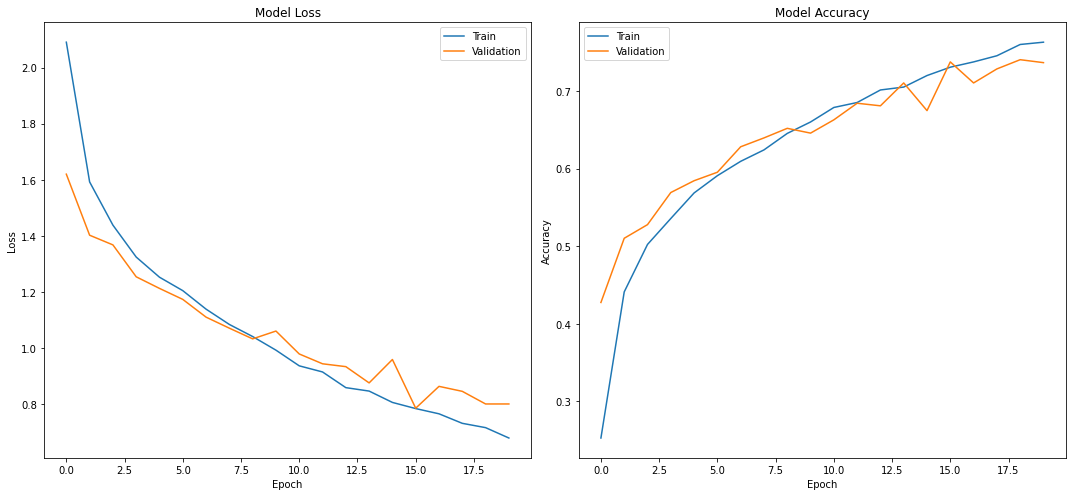

CPU times: total: 6h 13min 34s
Wall time: 57min 36s


In [19]:
%%time

# PLEASE RUN BELOW CELL TO SKIP THE TRAINING
# fit the model
history = my_CNN.fit(train_generator, 
                    epochs=30, 
                    verbose=1, 
                    validation_data = val_generator, 
                    callbacks=[early_stop])

# plotting training loss and val loss
plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

# save our CNN model
my_CNN.save('my_CNN_final.h5')

In [20]:
# PLEASE RUN THIS CELL TO SKIP THE TRAINING
# load our model if needed
try:
    my_CNN
except:
    my_CNN = load_model('my_CNN_final.h5')

By looking at the model accuracy for training and validation set, we can see that our validation accuracy surpasses training accuracy during the last couple of epochs. This may indicate that our model still have some potential in prediction power. But for now, we will stop there to avoid overfitting. Fine tuning our model may requires a lot more trails on different parameters, layer width and depth, etc. 

We can set up a test image data generator to evaluate our model. Note that this should be similar to our validation generator, where we don't specify any transformations. 

In [21]:
# apply the same rescaling factor as our test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=269,
                                                  class_mode='categorical')

# load our images
# note that flatten is set to be False, as our CNN takes 4D tensor input
X_test, y_test = generator_to_df(test_generator, flatten=False)

Found 2126 images belonging to 15 classes.
2126 images were loaded into DataFrame.


In [22]:
# evaluate the model's performance on the test data
score = my_CNN.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

67/67 [==============================] - 6s 89ms/step - loss: 0.7721 - accuracy: 0.7371
Test loss: 0.7720795273780823
Test accuracy: 0.7370648980140686


After try-outs for several model structures, it appears that our CNN model did a pretty good job. Given this relatively simple structure, we can achieve up to 77% of accuracy within a relatively short time. We can take a look at the confusion matrix to see which are the species that are the most confusing. 

In [23]:
# predict our test set
# notice that this returns a matrix of probabilities
X_test, y_test = generator_to_df(test_generator, flatten=False)

y_predict = my_CNN.predict(X_test)

2126 images were loaded into DataFrame.


In [24]:
# flatten our predictions and true values
y_predict = np.argmax(y_predict, axis=1)
y_test = np.argmax(y_test, axis=1)

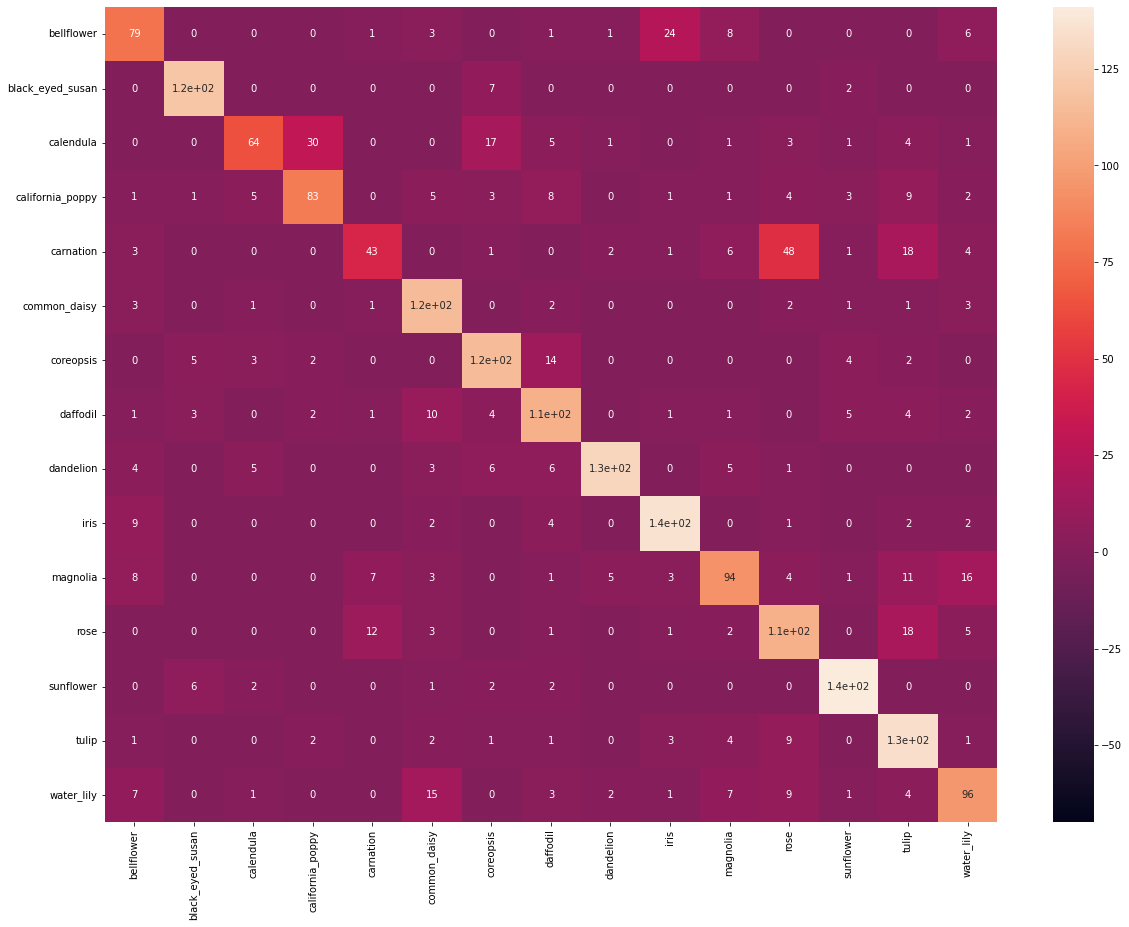

In [25]:
# set up our confusion matrix for plotting
cm = confusion_matrix(y_test, y_predict)
cm = pd.DataFrame(cm, columns=species_list, index=species_list)

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, vmin=-70)
plt.show()

# Transfer Learning with VGG16

Let's try to furthe push the limit of our predictive power. We will incoporate transfer learning with the well developed `VGG16` model and see how much this can improve our accuracy. 

In [26]:
# first, let's take a look at the original VGG16 model
vgg = VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Here, we will chop off the top layers (dense layers and output layers) and change the input shape to our desired shape. The hidden layers will be set to non-trainable as well, as they are already trained and we would like to keep those weights. 

In [27]:
# Import the pretrained VGG16 network, do not include the top layers
vgg = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(height, width, channels))

vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [28]:
# setting all layers to non-trainable
for layer in vgg.layers:
    layer.trainable=False

Let's set up a new CNN model with the trained layers followed by some dense layers of our choice. 

In [29]:
# instantiate a new CNN model
CNN_transfer = Sequential()

# add the pretrained layers 
CNN_transfer.add(vgg)

# add fully-connected dense layers of our choice -- plus dropout layers to help prevent overfitting
CNN_transfer.add(Dense(512, activation='relu'))
CNN_transfer.add(Dropout(0.5))
CNN_transfer.add(Dense(256, activation='relu'))
CNN_transfer.add(Dropout(0.2))
CNN_transfer.add(Dense(128, activation='relu'))
CNN_transfer.add(Dense(64, activation='relu'))

# adding our activation 
CNN_transfer.add(Dense(n_classes, activation='softmax'))

# compiling the transfer learning model, with learning rate 0.002 to speed up model training
CNN_transfer.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary 
CNN_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

Let's time our model training. This time, we will train for 60 epochs without early stopping. 

Epoch 1/60
308/308 [==============================] - 241s 783ms/step - loss: 2.0643 - accuracy: 0.3168 - val_loss: 1.3864 - val_accuracy: 0.5473
Epoch 2/60
308/308 [==============================] - 239s 777ms/step - loss: 1.4327 - accuracy: 0.5263 - val_loss: 1.0751 - val_accuracy: 0.6472
Epoch 3/60
308/308 [==============================] - 240s 780ms/step - loss: 1.2664 - accuracy: 0.5899 - val_loss: 0.9591 - val_accuracy: 0.6952
Epoch 4/60
308/308 [==============================] - 241s 784ms/step - loss: 1.1747 - accuracy: 0.6184 - val_loss: 0.9403 - val_accuracy: 0.6928
Epoch 5/60
308/308 [==============================] - 241s 781ms/step - loss: 1.1119 - accuracy: 0.6391 - val_loss: 0.8772 - val_accuracy: 0.7066
Epoch 6/60
308/308 [==============================] - 241s 783ms/step - loss: 1.0886 - accuracy: 0.6489 - val_loss: 0.8480 - val_accuracy: 0.7185
Epoch 7/60
308/308 [==============================] - 240s 779ms/step - loss: 1.0571 - accuracy: 0.6596 - val_loss: 0.8214 -

Epoch 57/60
308/308 [==============================] - 248s 805ms/step - loss: 0.6990 - accuracy: 0.7730 - val_loss: 0.6513 - val_accuracy: 0.7932
Epoch 58/60
308/308 [==============================] - 249s 807ms/step - loss: 0.6967 - accuracy: 0.7743 - val_loss: 0.6588 - val_accuracy: 0.7974
Epoch 59/60
308/308 [==============================] - 248s 806ms/step - loss: 0.6991 - accuracy: 0.7742 - val_loss: 0.6518 - val_accuracy: 0.7974
Epoch 60/60
308/308 [==============================] - 252s 818ms/step - loss: 0.7022 - accuracy: 0.7726 - val_loss: 0.6594 - val_accuracy: 0.7884


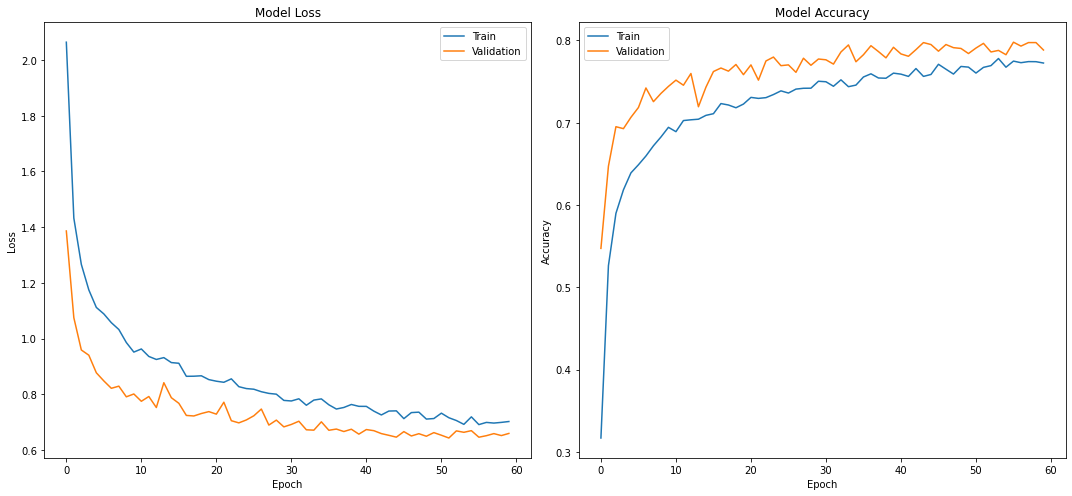

CPU times: total: 1d 6h 1min 4s
Wall time: 4h 7min 54s


In [30]:
%%time

# PLEASE RUN BELOW CELL TO SKIP THE TRAINING
# Fitting the model to the training data
transfer_history = CNN_transfer.fit(train_generator,
                                epochs=60,
                                validation_data=val_generator)

# plotting training loss and val loss
plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['loss'])
plt.plot(transfer_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['accuracy'])
plt.plot(transfer_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

# save our transfer CNN model
CNN_transfer.save('CNN_transfer.h5')

In [31]:
# PLEASE RUN THIS CELL TO SKIP THE TRAINING
# load our model if needed
try:
    CNN_transfer
except:
    CNN_transfer = load_model('CNN_transfer.h5')

In [32]:
X_test.shape

(2126, 128, 128, 3)

In [33]:
# evaluate the model's performance on the test data
X_test, y_test = generator_to_df(test_generator, flatten=False)
score = CNN_transfer.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2126 images were loaded into DataFrame.
67/67 [==============================] - 42s 625ms/step - loss: 0.6490 - accuracy: 0.7992
Test loss: 0.6490300893783569
Test accuracy: 0.7991533279418945


It appears that our CNN - VGG16 model did an okay job compared to our previous one. CNN - VGG16 model increased our accuracy by 1%, at the cost of 1 more hour of training time. However, we can see that the training accuracy has been lower than our val accuracy for the entire training period. This indicates that our model still has some potential to be more predictive, probably around 85% accuracy, given sufficiently long time for training. 

Other than the accuracy, it's also worth looking at the metrics, precision and recall, which measures the following: 

1. **Precision**: Out of those labels our model predicted, how many labels are actually correct
2. **Recall**: Out of the actual labels, how many did our model correctly predict

In [34]:
# predict our test set
# notice that this returns a matrix of probabilities
y_predict = CNN_transfer.predict(X_test)
y_predict.shape

(2126, 15)

In [35]:
# flatten our predictions and true values
y_predict = np.argmax(y_predict, axis=1)
y_test = np.argmax(y_test, axis=1)

# print classification report
print(classification_report(y_test, y_predict, digits=16))

                  precision    recall  f1-score   support

               0  0.7906976744186046 0.5528455284552846 0.6507177033492823       123
               1  0.9120000000000000 0.8837209302325582 0.8976377952755905       129
               2  0.7307692307692307 0.5984251968503937 0.6580086580086580       127
               3  0.6917808219178082 0.8015873015873016 0.7426470588235294       126
               4  0.7355371900826446 0.7007874015748031 0.7177419354838708       127
               5  0.8770491803278688 0.8294573643410853 0.8525896414342631       129
               6  0.8333333333333334 0.7241379310344828 0.7749077490774907       145
               7  0.7911392405063291 0.8741258741258742 0.8305647840531561       143
               8  0.9741935483870968 0.9496855345911950 0.9617834394904460       159
               9  0.8171428571428572 0.9166666666666666 0.8640483383685802       156
              10  0.5739910313901345 0.8366013071895425 0.6808510638297872       153
      

Multi-class precision and recall can be hard to perceive, We can use a confusion matrix to help us understand. 

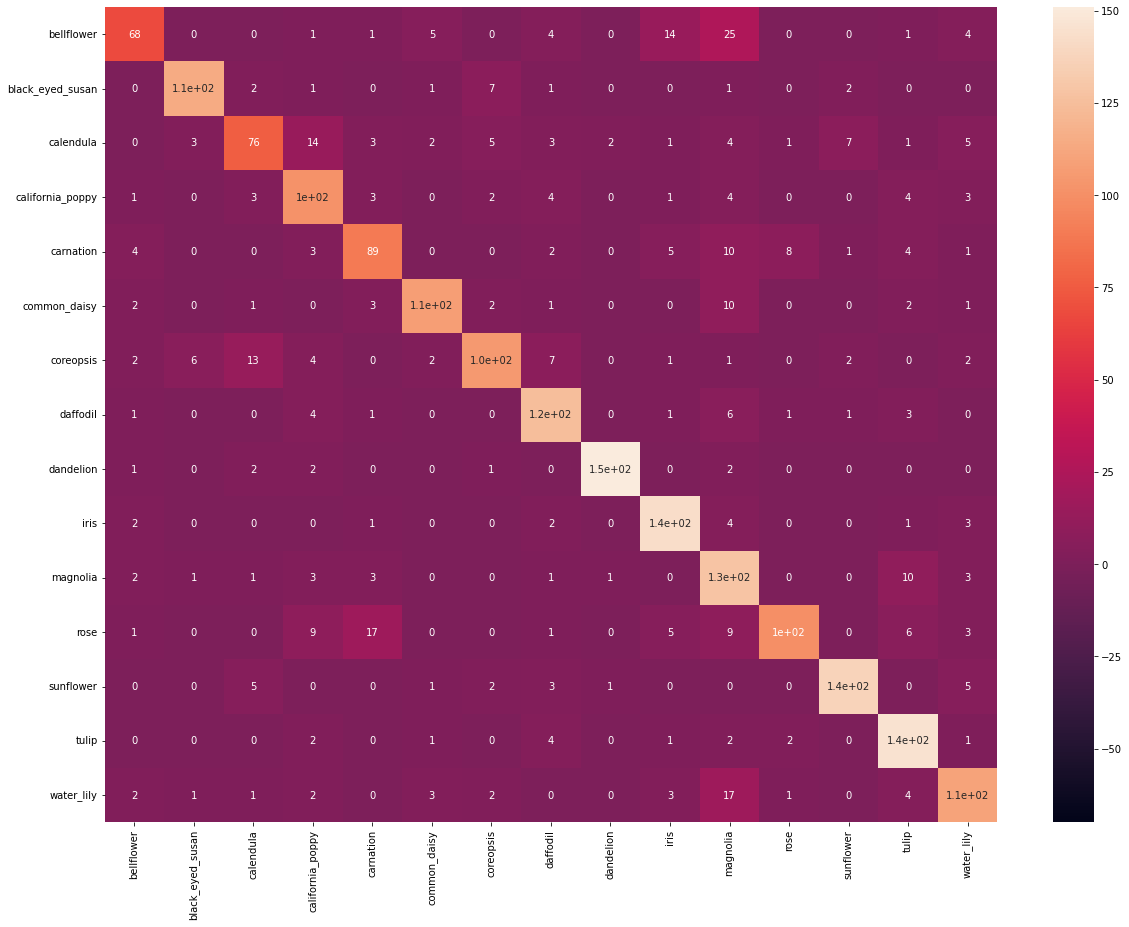

In [36]:
# set up our confusion matrix for plotting
cm = confusion_matrix(y_test, y_predict)
cm = pd.DataFrame(cm, columns=species_list, index=species_list)

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, vmin=-70)
plt.show()

We can also take a look at what are the images our model is struggling at. Looking at our confusion matrix, distinguishing between calendula and coreopsis, rose and carnation, iris and bellflower. Suprisingly enough, our CNN - VGG16 model did a bad job in predicting bellflower, compared to our original CNN. Mostly, it mixes bellflower and iris. 

If we can take a sample of the mis-classified images: 

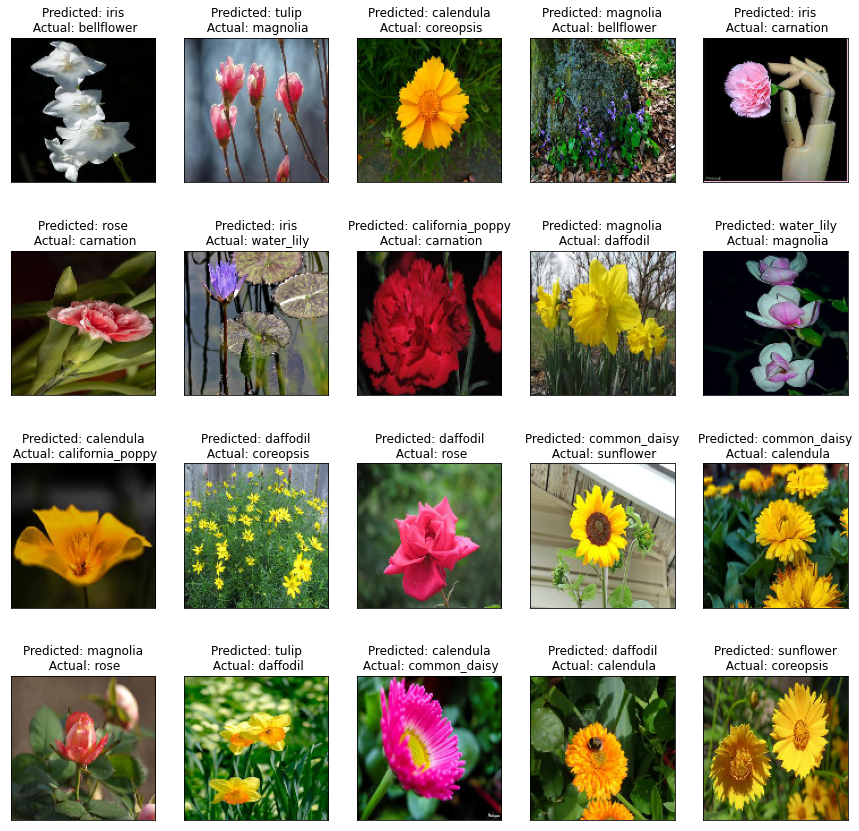

In [37]:
mis_labeled = y_test != y_predict

num_images = 20
columns = 5
rows = 4

fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 15))

ax = ax.flatten()

for i, image in enumerate(X_test[mis_labeled][:num_images]):
    ax[i].imshow(image)

    # Get predicted label
    prediction = y_predict[mis_labeled][i]
    prediction = species_list[prediction]
    
    # Get actual label
    actual = y_test[mis_labeled][i]
    actual = species_list[actual]
    
    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")
    
    # Hide the x and y ticks to make 
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])

plt.show()
fig.tight_layout()

Some of these images do seem confusing even to human. Other assumptions would be that, say for dandelion, flower from a certain stage of its life time may look like another species. Also, some variants in one species may also seem similar to another species. In order to address these problems, mroe detailed data cleaning processes are to be performed. 

Finally, let's play around with our prediction UI. 

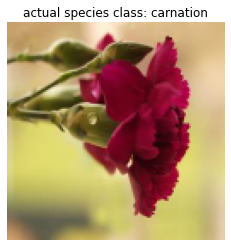

predicted to be tulip, with a probability of 1.0


In [38]:
model_predict(my_CNN, 'carnation/112479874_86d47acb53_c.jpg')

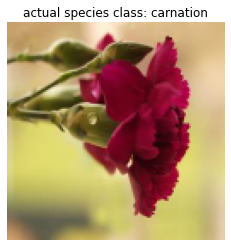

predicted to be tulip, with a probability of 1.0


In [39]:
model_predict(CNN_transfer, 'carnation/112479874_86d47acb53_c.jpg')

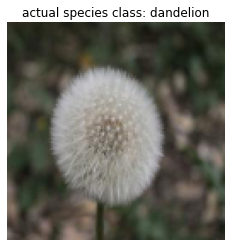

predicted to be daffodil, with a probability of 1.0


In [40]:
model_predict(my_CNN, 'dandelion/87228294_6b6530bd08_c.jpg')

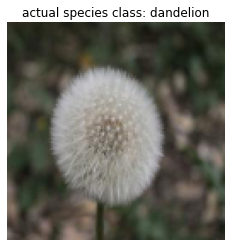

predicted to be dandelion, with a probability of 1.0


In [41]:
model_predict(CNN_transfer, 'dandelion/87228294_6b6530bd08_c.jpg')

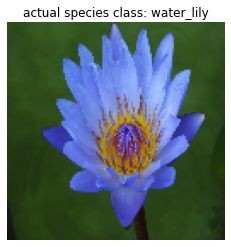

predicted to be water_lily, with a probability of 1.0


In [42]:
model_predict(my_CNN, 'water_lily/8663368518_90d6069bec_c.jpg')

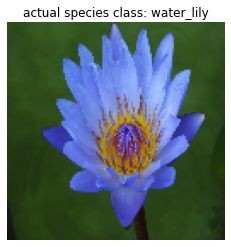

predicted to be common_daisy, with a probability of 1.0


In [43]:
model_predict(CNN_transfer, 'water_lily/8663368518_90d6069bec_c.jpg')

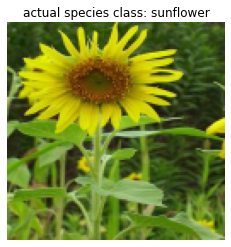

predicted to be black_eyed_susan, with a probability of 1.0


In [44]:
model_predict(my_CNN, 'sunflower/1193278641_bec50582cb_c.jpg')

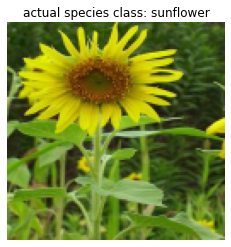

predicted to be common_daisy, with a probability of 1.0


In [45]:
model_predict(CNN_transfer, 'sunflower/1193278641_bec50582cb_c.jpg')